Flower Classification System using data provided on Kaggle.

In this project, I used standard CNN model to classify all 5 classes of Flowers 
and achieving accuracy upto 95%

In this project, overfitting is a huge concern due to smaller dataset
So in order to avoid that, we used prepocessing techniques like Data Augmentation and runtime techniques such as Batch normalization and regularlization

Importing Libraries

In [ ]:
import cv2, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
from sklearn.utils import shuffle
from tqdm import tqdm
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from contextlib import redirect_stdout
from keras import layers
from functools import partial


%matplotlib inline

Mounting Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Defining Neural Network Model

In [ ]:
"""
    Creating a Convolutional Neural Network having 5 Convolution layers and 3 Dense Layers
    The Convolution Layers will extract features and pass it on the dense layers
"""
def createModel():
    model = Sequential()

    # 5 layers of convolutions and Max Pooling using 'same' padding and 'ReLu' activation function
    model.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu', input_shape=(128,128,3))) #initial layer receiving input images
    model.add(MaxPool2D(pool_size=2, padding='same'))

    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), padding='same'))

    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=2, padding='same'))

    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=2, padding='same'))

    

    model.add(Dropout(0.2)) #Using dropout to avoid overfitting

    # The data coming from Conv and Pooling layers will be in shape (nx, ny ,channels) 
    # so in order to pass it into fully connected (Dense) layers,
    # we need to reshape it a single dimensional tensor
    # for this purpose we will use Flatten()

    model.add(Flatten()) 


    # Dense layers with L2 regularizer
    # L2 regularizer will 'regularize' the weights to avoid overfitting

    model.add(Dense(512,kernel_regularizer='l2' ,activation='relu'))

    tf.keras.layers.BatchNormalization()
    model.add(Dense(128,kernel_regularizer='l2' ,activation='relu'))
    model.add(Dropout(0.2))

    #Batch normalization to avoid overfitting

    tf.keras.layers.BatchNormalization()
    model.add(Dropout(rate=0.5))
    tf.keras.layers.BatchNormalization()

    model.add(Dense(5,kernel_regularizer='l2', activation='softmax'))
    
    return model

In [ ]:
model = createModel()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 256)        

Data Preprocessing

In [ ]:
"""
    Data preprocessing using ImageDataGenerator
"""
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255, # Data Normalization
        validation_split=0.3, #Making a validation set from training data
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  # Rotating data for augmentation
        zoom_range = 0.1,  #Zooming from range 0-0.1
        width_shift_range=0.2, 
        height_shift_range=0.2,  
        horizontal_flip=True, # Horizontally flipping the data for Augmentation
        vertical_flip=False  
       )

Training & Validation Data

In [ ]:
#Training set
train_generator = datagen.flow_from_directory(
           
            '/content/drive/My Drive/newFlowers/TrainData',
            target_size = (128,128),
            batch_size = 64,
            class_mode = 'categorical',
            subset="training"
            )
#Validation set
validation_generator = datagen.flow_from_directory(
       
            '/content/drive/My Drive/newFlowers/TrainData',
            target_size = (128,128),
            batch_size = 64,
            class_mode = 'categorical',
            subset="validation"
            )
    
    

Found 2921 images belonging to 5 classes.
Found 1248 images belonging to 5 classes.


Test Data

In [ ]:
#Test dataset
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
        rescale = 1./255,
        )

test_generator = test_datagen.flow_from_directory(
        directory=r"/content/drive/My Drive/newFlowers/TestData",
        target_size=(128, 128),
        color_mode="rgb",
        batch_size=8,
        class_mode="categorical"

    )


Found 20 images belonging to 5 classes.


In [ ]:
epoch=180
opt = Adam(lr = 0.001)

In [ ]:
model = createModel()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
hist = model.fit_generator(
                     train_generator,
                     epochs=epoch,
                     shuffle = True,
                     validation_data= validation_generator,
                     steps_per_epoch = 16,
                     verbose = 1
                     )




Epoch 1/180
16/16 [==============================] - 15s 937ms/step - loss: 8.7841 - accuracy: 0.2418 - val_loss: 5.2007 - val_accuracy: 0.3814
Epoch 2/180
16/16 [==============================] - 14s 904ms/step - loss: 3.6935 - accuracy: 0.3262 - val_loss: 2.6599 - val_accuracy: 0.2732
Epoch 3/180
16/16 [==============================] - 14s 903ms/step - loss: 2.3600 - accuracy: 0.3584 - val_loss: 1.9981 - val_accuracy: 0.3998
Epoch 4/180
16/16 [==============================] - 15s 919ms/step - loss: 1.8963 - accuracy: 0.3887 - val_loss: 1.7333 - val_accuracy: 0.3694
Epoch 5/180
16/16 [==============================] - 14s 906ms/step - loss: 1.6601 - accuracy: 0.3867 - val_loss: 1.5426 - val_accuracy: 0.4014
Epoch 6/180
16/16 [==============================] - 14s 896ms/step - loss: 1.5556 - accuracy: 0.3623 - val_loss: 1.4908 - val_accuracy: 0.3942
Epoch 7/180
16/16 [==============================] - 14s 887ms/step - loss: 1.4759 - accuracy: 0.3986 - val_loss: 1.4239 - val_accuracy:

In [ ]:
model.evaluate_generator(generator=test_generator, verbose = 1)

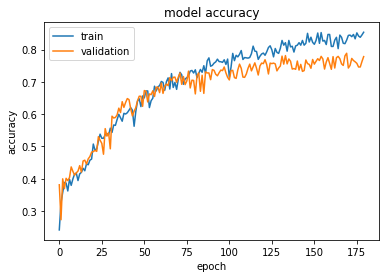

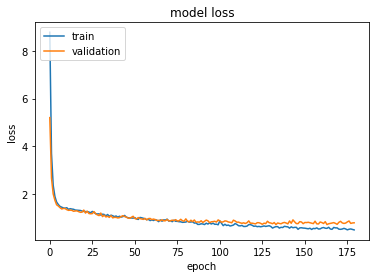

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, classifying the flower

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(128, 128))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0][0]>0:
    print(fn + " is a tulip")
  elif classes[0][1]>0:
    print(fn + " is a sunflower")
  elif classes[0][2]>0:
    print(fn + " is a rose")
  elif classes[0][3]>0:
    print(fn + " is a dandelion")
  else:
    print(fn + " is a daisy")
 


Saving 21134000558_d7d6c9b1fe_n.jpg to 21134000558_d7d6c9b1fe_n.jpg
[0. 0. 0. 1. 0.]
21134000558_d7d6c9b1fe_n.jpg is a dandelion
